Loading data...
Selected last 15000 rows.
Applying feature engineering...
Feature engineering complete. Took 0.02 seconds.
Columns after features: 51
Defining target variable...
Preparing data for modeling...
Handled NaNs. Dropped 185 rows.
Replacing 8 infinites...
Dropped 8 more rows.
Defining Features (X) and Binary Target (y)...
Final feature matrix shape: (14807, 42)
Target vector shape: (14807,)
Using 42 features.

--- Starting SLIDING Window Backtest with Per-Step HParam Tuning ---
!!! WARNING: This will be significantly slower due to GridSearchCV in each step !!!
Sliding Window: 1000, Step: 24, Tuning Grid Size: 24 combinations

--- Step 1 (Predicting for 2023-09-06 18:00:00) ---
  Training window: [0:999]
  Running GridSearchCV (cv=3, scoring='f1')...
  GridSearchCV finished in 3.78s.
  Best Params: {'colsample_bytree': 0.9, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.9}, Best CV F1: 0.7823
  Step 1 finished in 3.82s total.

--- Step 2 (Predicting for 2023-09-07 18:00:00

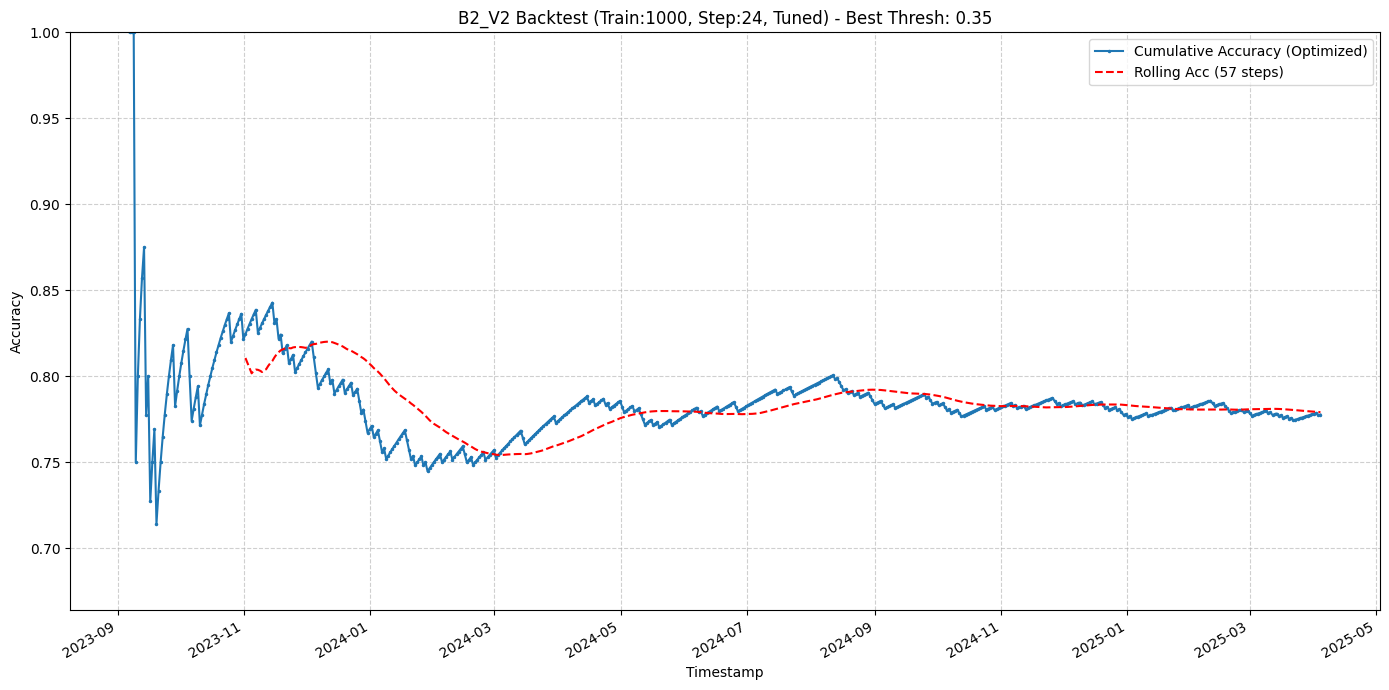


Script B2_V2.py finished.


In [1]:
# B2_V2.py
# Simple Predictor with Sliding Window, Per-Step HParam Tuning, and PTT

import pandas as pd
import numpy as np
import time
import os
import warnings
import traceback
from datetime import datetime
import xgboost as xgb
import matplotlib.pyplot as plt

# Modeling Imports
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, ParameterGrid # Added ParameterGrid for checking grid size
from sklearn.exceptions import UndefinedMetricWarning

# --- Suppress Warnings ---
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore')

# --- Configuration ---

# Data Loading & Feature Engineering (Identical to Simple_Predictor_B_Sliding - using custom functions)
# --- 1. Load Data and Select Last Rows ---
print("Loading data...")
try:
    df_full = pd.read_csv('BTCUSDrec.csv')
    df_full = df_full.sort_values(by='unix', ascending=True).reset_index(drop=True)
    if 'date' in df_full.columns:
        try: df_full['date'] = pd.to_datetime(df_full['date'])
        except Exception as e_date: print(f"Warning: Date parse error: {e_date}")
    N_ROWS_TO_USE = 15000
    if len(df_full) < N_ROWS_TO_USE: print(f"Warning: Data < {N_ROWS_TO_USE} rows. Using all {len(df_full)} rows."); df = df_full.copy()
    else: df = df_full.iloc[-N_ROWS_TO_USE:].reset_index(drop=True); print(f"Selected last {len(df)} rows.")
except FileNotFoundError: print("Error: BTCUSDrec.csv not found."); exit()
except Exception as e: print(f"Error loading data: {e}"); exit()

# --- 2. Feature Engineering ---
print("Applying feature engineering...")
start_fe = time.time()
base_cols_numeric = ['open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD']
for col in base_cols_numeric:
    if col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce')
    else: print(f"Warning: Missing base column '{col}'"); df[col] = 0
if df[['open', 'high', 'low', 'close']].isnull().any().any():
    print("Warning: OHLC NaNs found. Dropping rows."); df = df.dropna(subset=['open', 'high', 'low', 'close'])
if df.empty: exit("Error: Empty DF after initial OHLC NaN drop.")
# Feature functions (assuming they add columns based on base_cols_numeric)
# --- Add the custom feature functions back ---
def garman_klass_volatility(o, h, l, c, w):
    with np.errstate(divide='ignore', invalid='ignore'): log_hl=np.log(h/l.replace(0,np.nan)); log_co=np.log(c/o.replace(0,np.nan))
    gk = 0.5*(log_hl**2) - (2*np.log(2)-1)*(log_co**2); gk = gk.fillna(0)
    rm = gk.rolling(w, min_periods=max(1,w//2)).mean(); rm = rm.clip(lower=0); return np.sqrt(rm)
def parkinson_volatility(h, l, w):
    with np.errstate(divide='ignore', invalid='ignore'): log_hl_sq = np.log(h/l.replace(0,np.nan))**2
    log_hl_sq = log_hl_sq.fillna(0); rs = log_hl_sq.rolling(w,min_periods=max(1,w//2)).sum()
    f = 1/(4*np.log(2)*w) if w>0 else 0; return np.sqrt(f*rs)
# -------------------------------------------

df['price_change_1h_temp'] = df['close'].pct_change()
with np.errstate(divide='ignore', invalid='ignore'):
    df['price_range_pct'] = (df['high'] - df['low']) / df['close'].replace(0, np.nan) * 100
    df['oc_change_pct'] = (df['close'] - df['open']) / df['open'].replace(0, np.nan) * 100

df['garman_klass_12h'] = garman_klass_volatility(df['open'],df['high'],df['low'],df['close'],12)
df['parkinson_3h'] = parkinson_volatility(df['high'],df['low'],3)
min_periods_rolling = 2
df['ma_3h'] = df['close'].rolling(3, min_periods=min_periods_rolling).mean()
df['rolling_std_3h'] = df['close'].rolling(3, min_periods=min_periods_rolling).std()
lag_periods_price = [3, 6, 12, 24, 48, 72, 168]; lag_periods_volume = [3, 6, 12, 24]
for lag in lag_periods_price: df[f'lag_{lag}h_price_return'] = df['price_change_1h_temp'].shift(lag) * 100
df['volume_return_1h'] = df['Volume BTC'].pct_change() * 100
for lag in lag_periods_volume: df[f'lag_{lag}h_volume_return'] = df['volume_return_1h'].shift(lag)
ma_periods = [6, 12, 24, 48, 72, 168]; std_periods = [6, 12, 24, 48, 72, 168]
for p in ma_periods: df[f'ma_{p}h'] = df['close'].rolling(p, min_periods=max(min_periods_rolling, p//2)).mean()
for p in std_periods: df[f'rolling_std_{p}h'] = df['price_change_1h_temp'].rolling(p, min_periods=max(min_periods_rolling, p//2)).std() * 100
df['prev_close']=df['close'].shift(1); df['hml']=df['high']-df['low']; df['hmpc']=np.abs(df['high']-df['prev_close']); df['lmpc']=np.abs(df['low']-df['prev_close'])
df['tr']=df[['hml','hmpc','lmpc']].max(axis=1)
atr_periods = [14, 24, 48]
for p in atr_periods: df[f'atr_{p}h'] = df['tr'].rolling(p, min_periods=max(1,p//2)).mean()
df = df.drop(columns=['prev_close', 'hml', 'hmpc', 'lmpc', 'tr'])
epsilon = 1e-9
for p in [24, 48, 168]:
    mc=f'ma_{p}h'; df[f'close_div_ma_{p}h'] = df['close']/(df[mc]+epsilon) if mc in df else np.nan # Renamed to match Simple_Predictor_B list
if 'ma_12h' in df and 'ma_48h' in df: df['ma12_div_ma48'] = df['ma_12h']/(df['ma_48h']+epsilon)
else: df['ma12_div_ma48']=np.nan
if 'ma_24h' in df and 'ma_168h' in df: df['ma24_div_ma168'] = df['ma_24h']/(df['ma_168h']+epsilon)
else: df['ma24_div_ma168']=np.nan
if 'rolling_std_12h' in df and 'rolling_std_72h' in df: df['std12_div_std72'] = df['rolling_std_12h']/(df['rolling_std_72h']+epsilon)
else: df['std12_div_std72']=np.nan
if 'price_range_pct' in df: df['volume_btc_x_range'] = df['Volume BTC'] * df['price_range_pct']
else: df['volume_btc_x_range']=np.nan
if 'rolling_std_3h' in df: df['rolling_std_3h_sq'] = df['rolling_std_3h']**2
else: df['rolling_std_3h_sq']=np.nan
if 'price_change_1h_temp' in df: df['price_return_1h_sq'] = df['price_change_1h_temp']**2 * 10000
else: df['price_return_1h_sq']=np.nan
if 'rolling_std_12h' in df: df['rolling_std_12h_sqrt'] = np.sqrt(df['rolling_std_12h'].clip(lower=0)+epsilon)
else: df['rolling_std_12h_sqrt']=np.nan
cols_to_drop_intermediate = ['price_change_1h_temp', 'volume_return_1h']
df = df.drop(columns=[col for col in cols_to_drop_intermediate if col in df.columns])

# --- Add the 'symbol' column back AFTER calculations if needed elsewhere, ---
# --- but ensure it's excluded from X for modeling ---
# df['symbol'] = 'BTCUSD' # Example if needed later, but keep out of X

print(f"Feature engineering complete. Took {time.time() - start_fe:.2f} seconds.")
print(f"Columns after features: {df.shape[1]}")


# --- 3. Define Target Variable ---
print("Defining target variable...")
df['target_return_12h'] = df['close'].shift(-12).sub(df['close']).div(df['close'].replace(0, np.nan)).mul(100)
target_col = 'target_return_12h'

# --- 4. Prepare Data for Modeling ---
print("Preparing data for modeling...")
# Define columns to keep separate from features
cols_to_keep = ['unix', 'date', target_col, 'symbol'] # Keep identifiers + target + symbol

# Identify potential feature columns (all others)
potential_feature_cols = [col for col in df.columns if col not in cols_to_keep]

# Ensure only numeric features are selected (excluding base OHLCV which might have crept in)
numeric_feature_cols = df[potential_feature_cols].select_dtypes(include=np.number).columns.tolist()
final_feature_cols = [col for col in numeric_feature_cols if col not in base_cols_numeric] # Explicitly remove base OHLCV

# Create the DataFrame ready for modeling
df_model_ready = df[final_feature_cols + cols_to_keep].copy() # Keep only selected features + keep_cols

# Handle NaNs (Drop rows with ANY NaN in features OR target)
initial_rows = len(df_model_ready); df_model_ready = df_model_ready.dropna(); final_rows = len(df_model_ready)
print(f"Handled NaNs. Dropped {initial_rows - final_rows} rows.")

# Handle potential Infinite values
numeric_cols = df_model_ready.select_dtypes(include=np.number).columns.tolist()
numeric_cols_check = [col for col in numeric_cols if col not in [target_col, 'unix']]
inf_mask = np.isinf(df_model_ready[numeric_cols_check]); inf_count = inf_mask.sum().sum()
if inf_count > 0:
    print(f"Replacing {inf_count} infinites..."); df_model_ready.replace([np.inf, -np.inf], np.nan, inplace=True)
    rows_b4 = len(df_model_ready); df_model_ready = df_model_ready.dropna(); print(f"Dropped {rows_b4 - len(df_model_ready)} more rows.")
if df_model_ready.empty: exit("Error: DataFrame empty after NaN/Inf handling.")

# Define final Features (X) and Binary Target (y)
print("Defining Features (X) and Binary Target (y)...")
# final_feature_cols is already defined correctly above
X = df_model_ready[final_feature_cols]
y_binary = (df_model_ready[target_col] >= 0).astype(int) # 1 if >=0% increase

# Get timestamps
if 'date' in df_model_ready.columns and pd.api.types.is_datetime64_any_dtype(df_model_ready['date']):
    timestamps = df_model_ready['date']
elif 'unix' in df_model_ready.columns:
    timestamps = pd.to_datetime(df_model_ready['unix'], unit='ms')
else:
    print("Warning: No date/unix. Using index for timestamps."); timestamps = pd.Series(df_model_ready.index)

print(f"Final feature matrix shape: {X.shape}"); print(f"Target vector shape: {y_binary.shape}"); print(f"Using {len(final_feature_cols)} features.")
# print("Final Feature Columns:", final_feature_cols) # Uncomment to verify


# --- 5. SLIDING Window Backtesting with Per-Step HParam Tuning ---
print("\n--- Starting SLIDING Window Backtest with Per-Step HParam Tuning ---")
print("!!! WARNING: This will be significantly slower due to GridSearchCV in each step !!!")

# Backtesting Parameters
train_window_size = 1000
step_size = 24
# Fixed XGBoost parameters
xgb_fixed_params = {
    'learning_rate': 0.1, 'objective': 'binary:logistic', 'eval_metric': 'logloss',
    'use_label_encoder': False, 'random_state': 42,
    'reg_alpha': 0.1, 'reg_lambda': 0.1, 'n_jobs': -1
}
# Parameter grid for GridSearchCV (24 combinations)
XGB_PARAM_GRID_TUNE = {
    'max_depth': [3, 4, 5], 'n_estimators': [50, 100],
    'subsample': [0.7, 0.9], 'colsample_bytree': [0.7, 0.9],
}
# Probability Threshold Tuning Range
THRESHOLD_SEARCH_RANGE = np.arange(0.10, 0.90, 0.05)

if len(X) < train_window_size + step_size:
     print(f"Error: Not enough data ({len(X)}) for train window ({train_window_size}) + step ({step_size})."); exit()

# Store results
all_predictions_proba = []; all_actual = []; backtest_timestamps = []
num_steps = 0
start_index_loop = train_window_size; end_index_loop = len(X)

print(f"Sliding Window: {train_window_size}, Step: {step_size}, Tuning Grid Size: {len(list(ParameterGrid(XGB_PARAM_GRID_TUNE)))} combinations")
loop_start_time = time.time() # Time the whole loop

for i in range(start_index_loop, end_index_loop, step_size):
    step_start_time = time.time()
    train_idx_start = i - train_window_size; train_idx_end = i; test_idx = i
    if test_idx >= len(X): break
    X_train_roll = X.iloc[train_idx_start : train_idx_end]
    y_train_roll = y_binary.iloc[train_idx_start : train_idx_end]
    X_test_roll = X.iloc[test_idx : test_idx + 1]
    y_test_roll_actual = y_binary.iloc[test_idx]
    current_timestamp = timestamps.iloc[test_idx]

    if X_train_roll.empty or len(np.unique(y_train_roll)) < 2:
        print(f"Warning: Skipping index {test_idx}. Invalid training data."); continue

    print(f"\n--- Step {num_steps + 1} (Predicting for {current_timestamp}) ---")
    print(f"  Training window: [{train_idx_start}:{train_idx_end-1}]")

    # --- Hyperparameter Tuning ---
    print(f"  Running GridSearchCV (cv=3, scoring='f1')...")
    grid_search_start_time = time.time()
    try:
        estimator = xgb.XGBClassifier(**xgb_fixed_params)
        grid_search = GridSearchCV(
            estimator=estimator, param_grid=XGB_PARAM_GRID_TUNE, scoring='f1',
            cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=i),
            n_jobs=-1, verbose=0
        )
        grid_search.fit(X_train_roll, y_train_roll) # Fit GridSearch
        best_params_step = grid_search.best_params_
        best_score_step = grid_search.best_score_
        print(f"  GridSearchCV finished in {time.time() - grid_search_start_time:.2f}s.")
        print(f"  Best Params: {best_params_step}, Best CV F1: {best_score_step:.4f}")

        # --- Fit final model for the step ---
        final_model_params = {**xgb_fixed_params, **best_params_step}
        model_roll = xgb.XGBClassifier(**final_model_params)
        model_roll.fit(X_train_roll, y_train_roll, verbose=False) # Fit final model

        # --- Predict probability ---
        prob_roll = model_roll.predict_proba(X_test_roll)[0, 1]

        # --- Store results ---
        all_predictions_proba.append(prob_roll)
        all_actual.append(y_test_roll_actual)
        backtest_timestamps.append(current_timestamp)
        num_steps += 1

    except Exception as e_step:
        print(f"!! Error during GridSearch/Fit/Predict at index {test_idx}: {e_step}")
        traceback.print_exc() # Print full traceback for the error
        continue # Skip to next step

    step_end_time = time.time()
    print(f"  Step {num_steps} finished in {step_end_time - step_start_time:.2f}s total.")

loop_end_time = time.time()
print(f"\nBacktesting loop finished. Completed {num_steps} steps in {(loop_end_time - loop_start_time)/60:.2f} minutes.")

# --- 6. Evaluate Backtesting Results with PTT ---
if num_steps > 0 and len(all_predictions_proba) == len(all_actual):
    print("\n--- Evaluating Results with Probability Threshold Tuning ---")
    print(f"Threshold search range: {THRESHOLD_SEARCH_RANGE}")
    best_threshold = 0.5; best_f1_thresh = -1.0
    results_per_threshold = {}
    probabilities_np = np.array(all_predictions_proba); actual_np = np.array(all_actual)

    for t in THRESHOLD_SEARCH_RANGE:
        predictions_thresh = (probabilities_np >= t).astype(int)
        # Ensure there are predicted positives before calculating precision/recall/f1
        if np.sum(predictions_thresh) == 0 and np.sum(actual_np) > 0:
             # Handle case where threshold is too high -> no positive predictions
             f1_t = 0.0; pre_t = 0.0; rec_t = 0.0
        elif np.sum(actual_np) == 0 and np.sum(predictions_thresh) > 0:
             # Handle case where only negative samples exist but model predicts positive
              f1_t = 0.0; pre_t = 0.0; rec_t = 0.0 # Or handle as appropriate (e.g., undefined)
        elif np.sum(actual_np) == 0 and np.sum(predictions_thresh) == 0:
             # Only negative samples, only negative predictions -> perfect recall for neg, F1 undefined/1?
             f1_t = 1.0 if accuracy_score(actual_np, predictions_thresh) == 1.0 else 0.0 # Treat perfect accuracy as F1=1
             pre_t = 1.0 if accuracy_score(actual_np, predictions_thresh) == 1.0 else 0.0
             rec_t = 0.0 # Recall for positive class is 0
        else:
             # Normal case with both classes present or predictable
             pre_t = precision_score(actual_np, predictions_thresh, zero_division=0)
             rec_t = recall_score(actual_np, predictions_thresh, zero_division=0)
             f1_t = f1_score(actual_np, predictions_thresh, zero_division=0)

        acc_t = accuracy_score(actual_np, predictions_thresh)
        results_per_threshold[round(t, 2)] = {'f1': f1_t, 'acc': acc_t, 'pre': pre_t, 'rec': rec_t}
        if f1_t >= best_f1_thresh: # Use >= to prefer higher threshold if F1 is equal
            best_f1_thresh = f1_t; best_threshold = t

    print(f"\nBest Threshold: {best_threshold:.2f} (Yielding F1: {best_f1_thresh:.4f})")

    final_predictions_optimized = (probabilities_np >= best_threshold).astype(int)
    final_accuracy = accuracy_score(actual_np, final_predictions_optimized)
    final_precision = precision_score(actual_np, final_predictions_optimized, zero_division=0)
    final_recall = recall_score(actual_np, final_predictions_optimized, zero_division=0)
    final_f1 = f1_score(actual_np, final_predictions_optimized, zero_division=0) # Recalculate F1 just to be sure

    print("\n--- Final Performance Metrics (Optimized Threshold) ---")
    print(f"Overall Accuracy:  {final_accuracy:.4f}")
    print(f"Overall Precision: {final_precision:.4f}")
    print(f"Overall Recall:    {final_recall:.4f}")
    print(f"Overall F1 Score:  {final_f1:.4f}")

    if 0.5 in results_per_threshold:
        res_def = results_per_threshold[0.5]
        print(f"\n(Compare: Default 0.5 Thresh -> Acc:{res_def['acc']:.4f}, Prc:{res_def['pre']:.4f}, Rec:{res_def['rec']:.4f}, F1:{res_def['f1']:.4f})")

    # --- 7. Plot Cumulative Accuracy ---
    print("\nPlotting cumulative accuracy (optimized threshold)...")
    cumulative_accuracy_list_optimized = (np.cumsum(final_predictions_optimized == actual_np) / np.arange(1, num_steps + 1))
    try:
        plt.figure(figsize=(14, 7))
        plt.plot(backtest_timestamps, cumulative_accuracy_list_optimized, marker='.', linestyle='-', markersize=3, label='Cumulative Accuracy (Optimized)')
        rolling_window_plot = min(num_steps // 10, 200)
        if num_steps > rolling_window_plot:
             rolling_acc = pd.Series(cumulative_accuracy_list_optimized).rolling(window=rolling_window_plot).mean()
             plt.plot(backtest_timestamps, rolling_acc, linestyle='--', color='red', label=f'Rolling Acc ({rolling_window_plot} steps)')
        plt.title(f'B2_V2 Backtest (Train:{train_window_size}, Step:{step_size}, Tuned) - Best Thresh: {best_threshold:.2f}')
        plt.xlabel('Timestamp'); plt.ylabel('Accuracy')
        min_y_plot = max(0.0, np.min(cumulative_accuracy_list_optimized) - 0.05 if len(cumulative_accuracy_list_optimized)>0 else 0.4)
        max_y_plot = min(1.0, np.max(cumulative_accuracy_list_optimized) + 0.05 if len(cumulative_accuracy_list_optimized)>0 else 0.8)
        plt.ylim(min_y_plot, max_y_plot)
        plt.grid(True, linestyle='--', alpha=0.6); plt.legend(); plt.xticks(rotation=30, ha='right'); plt.tight_layout(); plt.show()
    except Exception as e_plot: print(f"Error plotting: {e_plot}")

else:
    print("No predictions were made/stored, cannot evaluate or plot.")

print("\nScript B2_V2.py finished.")

In [4]:
X.columns

Index(['open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD',
       'price_range_pct', 'oc_change_pct', 'garman_klass_12h', 'parkinson_3h',
       'ma_3h', 'rolling_std_3h', 'lag_3h_price_return', 'lag_6h_price_return',
       'lag_12h_price_return', 'lag_24h_price_return', 'lag_48h_price_return',
       'lag_72h_price_return', 'lag_168h_price_return', 'volume_return_1h',
       'lag_3h_volume_return', 'lag_6h_volume_return', 'lag_12h_volume_return',
       'lag_24h_volume_return', 'ma_6h', 'ma_12h', 'ma_24h', 'ma_48h',
       'ma_72h', 'ma_168h', 'rolling_std_6h', 'rolling_std_12h',
       'rolling_std_24h', 'rolling_std_48h', 'rolling_std_72h',
       'rolling_std_168h', 'atr_14h', 'atr_24h', 'atr_48h', 'close_div_ma_24h',
       'close_div_ma_48h', 'close_div_ma_168h', 'ma12_div_ma48',
       'ma24_div_ma168', 'std12_div_std72', 'volume_btc_x_range',
       'rolling_std_3h_sq', 'price_return_1h_sq', 'rolling_std_12h_sqrt'],
      dtype='object')

What Now?

This is great progress! It tells you that predicting 12-hour direction is a much more promising path with your data and feature types.

Stick with the Simpler Structure (for now): Keep the single model (XGBoost) and the expanding window backtest for now.

Optimize This Setup:

Apply VIF: Now that you have a working model structure and a seemingly viable target, apply VIF filtering (e.g., threshold 5 or even your strict 1.69) to the features generated in this simpler script. Does reducing collinearity now improve the already decent results?

Tune Hyperparameters: Tune the XGBoost parameters (n_estimators, max_depth, learning_rate, reg_alpha, reg_lambda, subsample, colsample_bytree, min_child_weight) using a method like Optuna or RandomizedSearchCV within the rolling backtest loop (similar to how the meta-learner was tuned, but now for the single main model).

Experiment with Target Horizon: Is 12 hours optimal for the >0% target? Try 8 hours, 24 hours.

Experiment with Training Window: Does the expanding window work best, or would a large sliding window perform better for this target?

You've found a much better baseline. Now optimize it systematically!